In [1]:
import pandas as pd
import pickle
import copy
import matplotlib.pyplot as plt
import networkx as nx

# Leitura e pré-processamento dos dados para a criação da matrix de localização

In [2]:
df = pd.read_csv('/home/gustavo/Desktop/Mestrado/mestrado_dados/dados_18.11/df_main_full.csv', index_col=False)
df.drop(columns={'Unnamed: 0'}, inplace=True)

In [3]:
df_reduced = pd.read_csv('/home/gustavo/Desktop/Mestrado/mestrado_dados/dados_18.11/class_sjdr.csv')
df_reduced.rename(columns={'ANTENNA_ID': 'PRESUMED_RESIDENCE'}, inplace=True)
df = pd.merge(df, df_reduced[['PRESUMED_RESIDENCE', 'classe']], on='PRESUMED_RESIDENCE')
df

,DATE,HOUR,DURATION,DDD_USER_FROM,USER_FROM,DDD_USER_TO,USER_TO,ANTENNA,8,9,10,11,12,13,14,DAY_OF_WEEK,ANTENNA_ID,PRESUMED_RESIDENCE,classe
0,2013-04-03,17:09:03,0.80,83.0,00003F26576D1122848B6F3CEEC250E5,83.0,FFA5E22189ED7ADEB364CFEB18205B59,50141.0,NaN,117.0,LOCAL,OI,OI,PRE PAGO,300000210.0,Wednesday,SJDR5,SJDR5,3
1,2013-04-09,15:34:30,5.12,83.0,00003F26576D1122848B6F3CEEC250E5,83.0,CCA21FFF10C7EC088827F5D5770D3274,50141.0,NaN,117.0,LOCAL,OI,OI,PRE PAGO,300000210.0,Tuesday,SJDR5,SJDR5,3
2,2013-04-09,15:23:38,1.53,83.0,00003F26576D1122848B6F3CEEC250E5,-4.0,64142FC9CDA8A82085271FB9D25FCDBF,50141.0,NaN,299.0,SERVICO NAO GEOGRAFICO,OI,TNL,PRE PAGO,300000210.0,Tuesday,SJDR5,SJDR5,3
3,2013-04-10,16:26:16,0.35,83.0,00003F26576D1122848B6F3CEEC250E5,83.0,BD288CE0AB2A0B5E57EB635FBF814C80,50141.0,NaN,117.0,LOCAL,OI,OI,PRE PAGO,300000210.0,Wednesday,SJDR5,SJDR5,3
4,2013-04-12,22:47:37,0.07,83.0,00003F26576D1122848B6F3CEEC250E5,83.0,8BA3ED7CA5B5E5D556AF30AE93D578FD,50141.0,NaN,117.0,LOCAL,OI,OI,PRE PAGO,300000210.0,Friday,SJDR5,SJDR5,3
5,2013-04-13,19:53:04,0.87,83.0,00003F26576D1122848B6F3CEEC250E5,83.0,73DBAC87ED341B9B1C0E9DC785C78821,50141.0,NaN,117.0,LOCAL,OI,OI,PRE PAGO,300000210.0,Saturday,SJDR5,SJDR5,3
6,2013-04-13,13:57:49,0.38,83.0,00003F26576D1122848B6F3CEEC250E5,83.0,65DE41CBC83929E9E926C2DD922D5F5B,50141.0,NaN,117.0,LOCAL,OI,OI,PRE PAGO,300000210.0,Saturday,SJDR5,SJDR5,3
7,2013-04-14,20:54:33,0.12,83.0,00003F26576D1122848B6F3CEEC250E5,21.0,A49BA005920B8BA24BEE40F455B69B9B,50141.0,NaN,117.0,LOCAL,OI,OI,PRE PAGO,300000210.0,Sunday,SJDR5,SJDR5,3
8,2013-04-14,20:57:52,4.85,83.0,00003F26576D1122848B6F3CEEC250E5,83.0,65DE41CBC83929E9E926C2DD922D5F5B,50141.0,NaN,117.0,LOCAL,OI,OI,PRE PAGO,300000210.0,Sunday,SJDR5,SJDR5,3
9,2013-04-15,14:58:32,1.30,83.0,00003F26576D1122848B6F3CEEC250E5,83.0,65DE41CBC83929E9E926C2DD922D5F5B,50141.0,NaN,117.0,LOCAL,OI,OI,PRE PAGO,300000210.0,Monday,SJDR5,SJDR5,3


In [4]:
df.dropna(subset=['DATE'], inplace=True)
df['HOUR'] = df['HOUR'].apply(lambda x: str(x))
df['TIME_RANGE'] = [str(x.split(':')[0]) for x in df['HOUR']]

In [5]:
df['TIME_RANGE'] = df['TIME_RANGE'].apply(lambda x: int(x))
df['TIME_RANGE'].unique()

array([17, 15, 16, 22, 19, 13, 20, 14,  9,  7, 10, 11,  8, 18,  6, 12, 21,
        0,  2,  5,  4, 23,  1,  3])

In [6]:
df.loc[(df['DAY_OF_WEEK'] == 'Saturday') | (df['DAY_OF_WEEK'] == 'Sunday'), 'TIME_RANGE'] = df['TIME_RANGE'] + 24

In [7]:
df_2 = df.loc[df['classe'] == 2]
df_3 = df.loc[df['classe'] == 3]

In [8]:
df_reduced = df[['USER_FROM', 'ANTENNA_ID', 'TIME_RANGE']]
df_reduced_2 = df_2[['USER_FROM', 'ANTENNA_ID', 'TIME_RANGE']]
df_reduced_3 = df_3[['USER_FROM', 'ANTENNA_ID', 'TIME_RANGE']]

# Criação da matrix de localização

In [9]:
location_matrix = df_reduced.groupby([*df_reduced.columns]).size()
location_matrix = location_matrix.unstack([1,2]).stack(dropna=False).fillna(0, downcast='infer')

location_matrix_2 = df_reduced_2.groupby([*df_reduced_2.columns]).size()
location_matrix_2 = location_matrix_2.unstack([1,2]).stack(dropna=False).fillna(0, downcast='infer')

location_matrix_3 = df_reduced_3.groupby([*df_reduced_3.columns]).size()
location_matrix_3 = location_matrix_3.unstack([1,2]).stack(dropna=False).fillna(0, downcast='infer')

# Vetores de trajetória

In [12]:
trajectory_vector = location_matrix.groupby(['USER_FROM']).sum()
trajectory_vector_2 = location_matrix_2.groupby(['USER_FROM']).sum()
trajectory_vector_3 = location_matrix_3.groupby(['USER_FROM']).sum()

# Similaridade entre os vetores

In [13]:
import scipy.spatial.distance as ssd
import numpy as np

In [14]:
trajectory_vector_array = trajectory_vector.to_numpy()

In [15]:
file = open('/home/gustavo/Desktop/Mestrado/mestrado_dados/Arquivos_Pickle/dict_edges.pkl', 'rb')
dict_edge = pickle.load(file)

In [16]:
len(dict_edge)

227399

In [17]:
def calculate_cosine_similarity(t_v, dict_edge):
    to_remove_dict = {}
    for key in dict_edge.keys():
        for k in key:
            if k in t_v.index:
                pass
            else:
                to_remove_dict[key] = dict_edge[key]
    tuples = set(dict_edge).difference(to_remove_dict)
    new_dict = {}
    for i in tuples:
        new_dict[i] = dict_edge[i]
    for key, value in zip(new_dict.keys(), new_dict.values()):
        x = t_v.loc[key[0]].to_numpy()
        y = t_v.loc[key[1]].to_numpy()
        cosine = 1 - ssd.cosine(x,y)
        value['Cosine_Similarity'] = cosine
    return new_dict

In [18]:
dt_geral = calculate_cosine_similarity(trajectory_vector, dict_edge)
dt_2 = calculate_cosine_similarity(trajectory_vector_2, dict_edge)
dt_3 = calculate_cosine_similarity(trajectory_vector_3, dict_edge)

In [19]:
t_v_2 = trajectory_vector_2.copy()
t_v_2['class'] = 2

t_v_3 = trajectory_vector_3.copy()
t_v_3['class'] = 3

t_v = t_v_3.append(t_v_2)
t_v

ANTENNA_ID,LD1,MDM,RT,SJDR1,SJDR2,SJDR3,SJDR4,SJDR5,ST,SVM,TR1,TR2,class
USER_FROM,,,,,,,,,,,,,
00003F26576D1122848B6F3CEEC250E5,0,0,0,0,0,0,0,12,0,0,0,0,3
0008B8E32E18BF4450B7CAAF0C1CE179,0,0,0,27,0,0,0,0,0,0,0,0,3
000A16372A762FD3BB2A59334780CDEA,0,0,0,9,2,0,0,0,0,0,0,0,3
000D1DF8B25B4C1728D16E1510BC72BE,0,0,0,0,0,0,0,22,0,0,0,0,3
000DDDA8D62CC0A09B505AA27279CCF8,0,0,0,13,0,0,0,0,0,0,0,0,3
000FBBADF9577F339DF263FD628D897C,0,0,0,0,0,0,23,0,0,0,0,0,3
000FEF29098C6C17FDE52CF7B3AD30A1,0,0,0,0,0,48,0,0,0,0,0,0,3
0014D12E96959533E7BBB4B574635B83,0,0,0,21,0,0,2,0,0,0,0,0,3
0015CBC1C07094CDFBE79A52AAF12FD5,0,0,0,0,0,42,0,0,0,0,0,0,3


In [20]:
from itertools import chain
def dict_union(*args):
    return dict(chain.from_iterable(d.items() for d in args))

dicts = dict_union(dt_geral, dt_2, dt_3)

In [21]:
for k, v in dicts.items():
    v['class_node_1'] = t_v['class'][list(k)[0]]
    v['class_node_2'] = t_v['class'][list(k)[1]]

In [22]:
df_similarity_num_calls = pd.DataFrame.from_dict(dicts, orient='index').reset_index()
df_similarity_num_calls.rename(columns={'level_0': 'Node_1', 'level_1': 'Node_2'}, inplace=True)
df_similarity_num_calls.sample(5)

,Node_1,Node_2,duration,numcalls,Cosine_Similarity,class_node_1,class_node_2
14238,AC41751C3BCC8AA49B51CC25BDEB21F7,0E90A76BD9DB649FDD55B5249C7C37B5,6.13,11,1.0,3,3
759,AB1D4A0A472CCF7046E9698F6D99B910,66CB5F35E36BC80336D5F35E06A1D741,3.37,11,1.0,3,3
5491,DCD6F952DF503A4FFA1E1E78A7BB494B,42842C8BDBD17F73B9F0B2E34FBCCA4C,1.16,3,1.0,2,2
2785,BA3EEBDA77F2196B896FBFE399110D87,9CC0B37C660B2292AC3E617D3739352A,94.77,45,1.0,2,2
280,FA4D71DE17B0443D285F052BD69466F7,31C3CF6E635CD5C92FC1C5B4027DFDE0,4.71,3,1.0,2,2


In [27]:
df_2_and_all = df_similarity_num_calls.loc[df_similarity_num_calls['class_node_1'] == 2]
df_2_and_2 = df_similarity_num_calls.loc[(df_similarity_num_calls['class_node_1'] == 2) & 
                                         (df_similarity_num_calls['class_node_2'] == 2)]
df_2_and_3 = df_similarity_num_calls.loc[(df_similarity_num_calls['class_node_1'] == 2) & 
                                         (df_similarity_num_calls['class_node_2'] == 3)]

df_3_and_all = df_similarity_num_calls.loc[df_similarity_num_calls['class_node_1'] == 3]
df_3_and_2 = df_similarity_num_calls.loc[(df_similarity_num_calls['class_node_1'] == 3) & 
                                         (df_similarity_num_calls['class_node_2'] == 2)]
df_3_and_3 = df_similarity_num_calls.loc[(df_similarity_num_calls['class_node_1'] == 3) & 
                                         (df_similarity_num_calls['class_node_2'] == 3)]

In [32]:
def sort_dataframes(dfs):
    new_df = []
    for df in dfs:
        df = df.groupby(['Cosine_Similarity','numcalls']).first().reset_index()
        df = df.sort_values(by=['numcalls', 'Cosine_Similarity'])
        new_df.append(df)
    return new_df
df = sort_dataframes([df_2_and_2,df_2_and_3,df_2_and_all,df_3_and_2, df_3_and_3, df_3_and_all])

In [33]:
df_new = []
for d in df:
    df_new.append(d.groupby('numcalls').mean().reset_index())

In [34]:
df_new[0]

,numcalls,Cosine_Similarity,duration,class_node_1,class_node_2
0,3,0.909570,3.364715,2,2
1,4,0.885329,4.240442,2,2
2,5,0.882717,5.611053,2,2
3,6,0.888869,6.488182,2,2
4,7,0.899389,6.042747,2,2
5,8,0.913992,7.056667,2,2
6,9,0.928782,8.479296,2,2
7,10,0.931951,9.562097,2,2
8,11,0.940674,12.185500,2,2
9,12,0.908803,11.111800,2,2


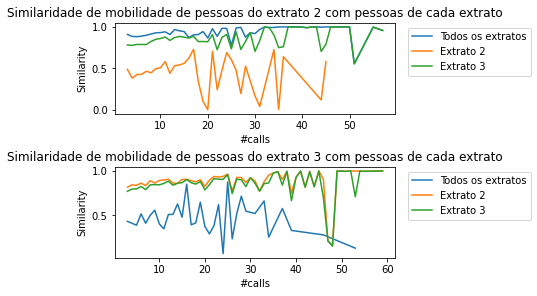

In [31]:
x1 = df_new[0]['numcalls'].to_numpy()
y1 = df_new[0]['Cosine_Similarity'].to_numpy()

x2 = df_new[1]['numcalls'].to_numpy()
y2 = df_new[1]['Cosine_Similarity'].to_numpy()

x3 = df_new[2]['numcalls'].to_numpy()
y3 = df_new[2]['Cosine_Similarity'].to_numpy()

_x1 = df_new[3]['numcalls'].to_numpy()
_y1 = df_new[3]['Cosine_Similarity'].to_numpy()

_x2 = df_new[4]['numcalls'].to_numpy()
_y2 = df_new[4]['Cosine_Similarity'].to_numpy()

_x3 = df_new[5]['numcalls'].to_numpy()
_y3 = df_new[5]['Cosine_Similarity'].to_numpy()

fig, (ax1, ax2) = plt.subplots(2,1, constrained_layout=True)

ax1.plot(x1, y1, label='Todos os extratos')
ax1.plot(x2, y2, label='Extrato 2')
ax1.plot(x3, y3, label='Extrato 3')

ax1.set_xlabel('#calls')
ax1.set_ylabel('Similarity')

ax1.set_title('Similaridade de mobilidade de pessoas do extrato 2 com pessoas de cada extrato')
ax1.legend(loc="upper right", bbox_to_anchor=(1.5, 1))

ax2.plot(_x1, _y1, label='Todos os extratos')
ax2.plot(_x2, _y2, label='Extrato 2')
ax2.plot(_x3, _y3, label='Extrato 3')

ax2.set_xlabel('#calls')
ax2.set_ylabel('Similarity')

ax2.set_title('Similaridade de mobilidade de pessoas do extrato 3 com pessoas de cada extrato')
ax2.legend(loc="upper right", bbox_to_anchor=(1.5, 1))


plt.show()

In [31]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()

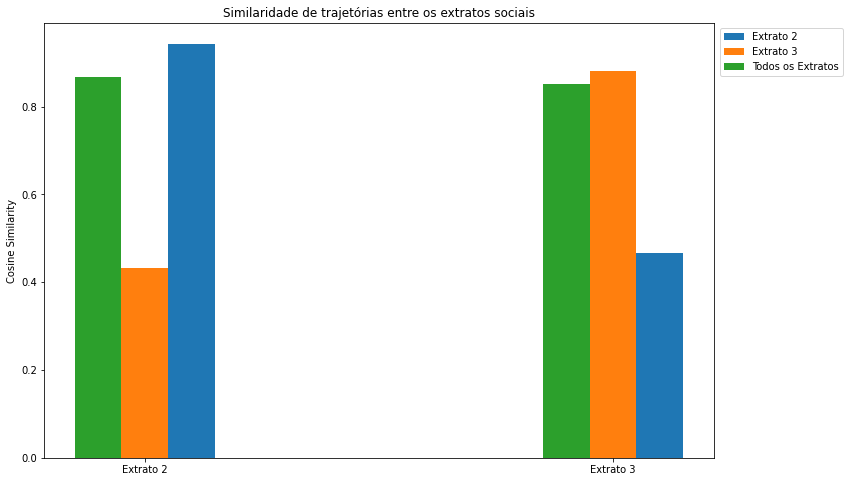

In [36]:
labels = ['Extrato 2', 'Extrato 3']

x = np.arange(len(labels))
width = 1

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x + 0.1, [np.mean(y1), np.mean(_y1)], width/10, label='Extrato 2')
rects2 = ax.bar(x, [np.mean(y2), np.mean(_y2)], width/10, label='Extrato 3')
rects3 = ax.bar(x - 0.1, [np.mean(y3), np.mean(_y3)], width/10, label='Todos os Extratos')

ax.set_ylabel('Cosine Similarity')
ax.set_title('Similaridade de trajetórias entre os extratos sociais')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.2, 1))

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


plt.show()